In [1]:
import sys
sys.path.append('../train/')

import math
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from util import array2mat

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bed12 = pd.read_table(
    "/lmh_data/data/sclab/public/hg19_gff3_tobed12.bed",
    header=None, index_col=None,names=[
        'chrom','start','end','name',"score","strand","thickStart","thickEnd","itemRgb",
        "blockCount","blockSizes","blockStarts"])
bed12.head(1)
bed12 = bed12[~bed12["name"].str.startswith("ENSG")]
bed12

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr1,11869,14409,DDX11L1,0,+,14409,14409,0,9,"358,108,1188,47,48,84,77,153,217","11869,12613,13221,12010,12179,12613,12975,1322..."
1,chr1,14404,29570,WASH7P,0,-,29570,29570,0,11,"36,153,98,146,136,135,197,158,151,33,97","29534,24738,18268,17915,17606,17233,16858,1660..."
2,chr1,29554,31109,MIR1302-2HG,0,+,31109,31109,0,5,"485,103,121,400,133","29554,30564,30976,30267,30976"
3,chr1,34554,36081,FAM138A,0,-,36081,36081,0,5,"360,204,620,352,236","35721,35277,34554,35721,35245"
4,chr1,52473,53312,OR4G4P,0,+,53312,53312,0,1,839,52473
...,...,...,...,...,...,...,...,...,...,...,...,...
60522,chrY,59318041,59318920,TRPC6P,0,-,59318920,59318920,0,1,879,59318041
60523,chrY,59330252,59343488,IL9R,0,+,59343488,59343488,0,20,"206,113,111,178,145,201,105,84,792,81,100,137,...","59330252,59335577,59336120,59336348,59337091,5..."
60524,chrY,59336889,59354907,AJ271736.1,0,+,59354907,59354907,0,4,"347,84,101,237","59336889,59340194,59354362,59354670"
60525,chrY,59347294,59349508,WASIR1,0,-,59349508,59349508,0,2,"175,877","59349333,59347294"


In [3]:
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy', allow_pickle=True)

In [4]:
def show_by_cell_type(cell_type):
    _pred, _target = None, None
    num = 0
    for i in range(len(preds)):
        pred = preds[i]
        if eval_set[i]['cell_type'] != cell_type:
            continue
        num += 1
        if _pred is None:
            _pred, _target = pred['predict'].copy(), pred['target'].copy()
        else:
            _pred += pred['predict']
            _target += pred['target']
    return _pred/num, _target/num

def _draw(mat):
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
#     ax.set_title('{}:{}-{}.{}.{}'.format(chrom, start, end, strand, cell_type))
    sns.heatmap(mat, cmap='Reds_r', square=True)

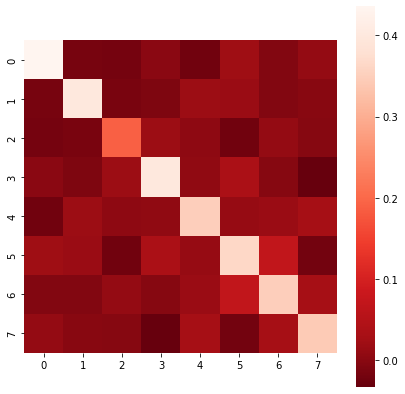

In [5]:
_pred, _target = show_by_cell_type('Endo')
_draw(array2mat(_pred))

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, cmap=mpl.cm.YlGnBu, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    #caxes = pl.pcolormesh(X, Y, np.fliplr(C), axes=axes, cmap=cmap, norm=norm)

    #norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=1)
    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)
    #caxes = axes.matshow(np.flipud(C), cmap=cmap, norm=norm)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
    colorbar_triangle(axes, caxes, ymax)
    
def plot_diag(ax, diag, ylabel, resolution=10000, yminx=5, ymaxx=95, rotation=0, fl='%0.2f', color='#464451'):
    ax.tick_params(bottom=False, top=False, left=True, right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = len(diag)

    width = 1
    ax.bar(x=range(0,x), height=diag, width=1, bottom=[0]*(x), color=color, align="edge", edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(diag, yminx)
    ymax = np.percentile(diag, ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')
    
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
#     print(gene_bed_plot)
    
    plot_gene_num = gene_bed_plot.shape[0]
#     print(plot_gene_num)
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = [int(x) for x in row["blockStarts"].split(",")]
            widths = [int(x) for x in row["blockSizes"].split(",")]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if row["name"] in gene_col:
                text_col = "red"
            #    ax.text(row['start'], plot_y+0.5, "  " + row['name'], ha='right', va='center',color=text_col, fontsize=fontszie)
                col = "red"
                
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = [int(x) for x in row["blockStarts"].split(",")]
            widths = [int(x) for x in row["blockSizes"].split(",")]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
            if (gene_bed_plot.iloc[-1]['name'] == row['name']) or (gene_bed_plot.iloc[-2]['name'] == row['name']) or (gene_bed_plot.iloc[-3]['name'] == row['name']):
                ax.text(row['start'], plot_y + 0.5, row['name'] + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
            else:
                ax.text(row['end'], plot_y + 0.5, "  " + row['name'], ha='left', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [7]:
def pre_track(predict_array):
    fig = plt.figure(figsize=(13, 8), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(13, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[9:13, 0], facecolor='white')

    _test = array2mat(predict_array)
    _test += abs(_test.min())
    row, col = np.diag_indices_from(_test)
    _diag = _test[row,col].copy()
    
    _test[row,col] = 0
    heatmap_triangle(ax0, _test, width=6, height=2.7, logData=False)
    # ax0.set_title("20:45000000-48000000 MMP9")
    
    plot_diag(ax1, _diag, 'diag')

    genename = 'PDGFRA'
    _gene = bed12[bed12['name']==genename]
    chrom = _gene['chrom'].values[0]
    start = int(_gene['start'].values[0]/10000)*10000
    end = int(_gene['end'].values[0]/10000)*10000 + 10000
    plot_gene(ax2, bed12, chrom, start, end, line=10, gene_col=[], fontszie=8)

    plt.show()

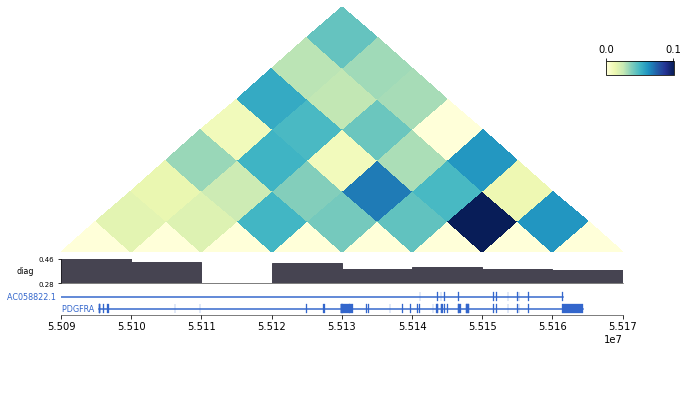

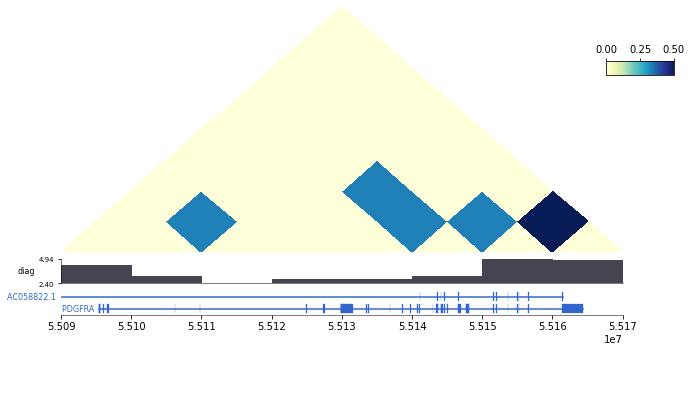

In [8]:
pre_track(show_by_cell_type('Endo')[0])
pre_track(show_by_cell_type('Endo')[1])

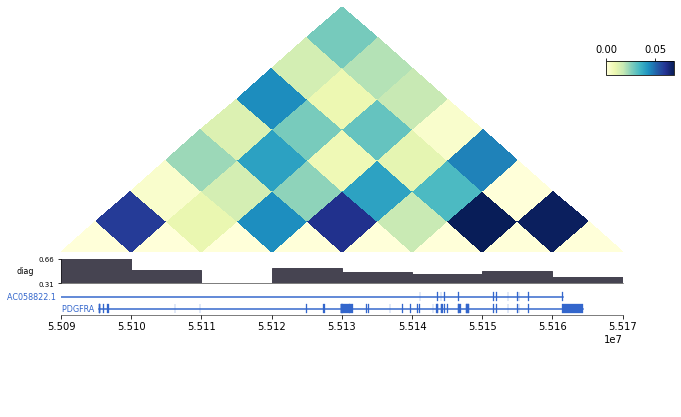

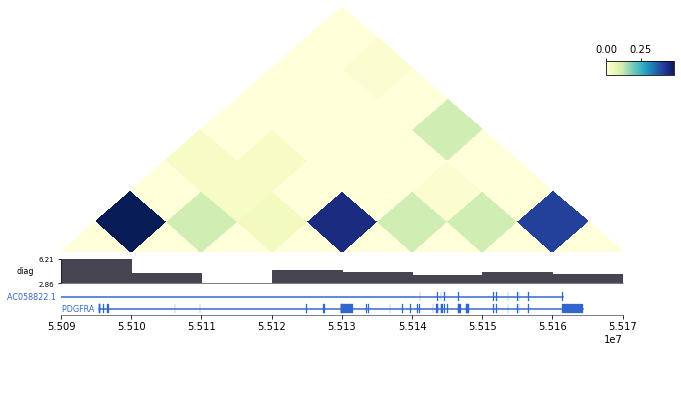

In [9]:
pre_track(show_by_cell_type('Astro')[0])
pre_track(show_by_cell_type('Astro')[1])

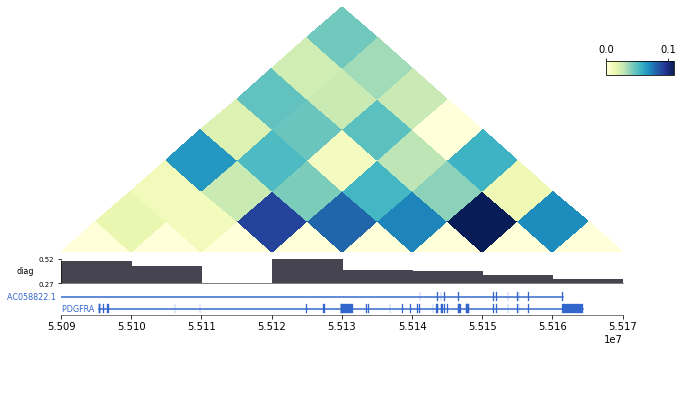

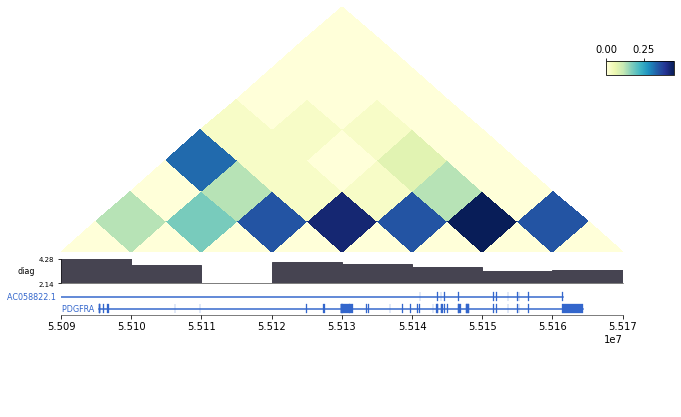

In [10]:
pre_track(show_by_cell_type('OPC')[0])
pre_track(show_by_cell_type('OPC')[1])

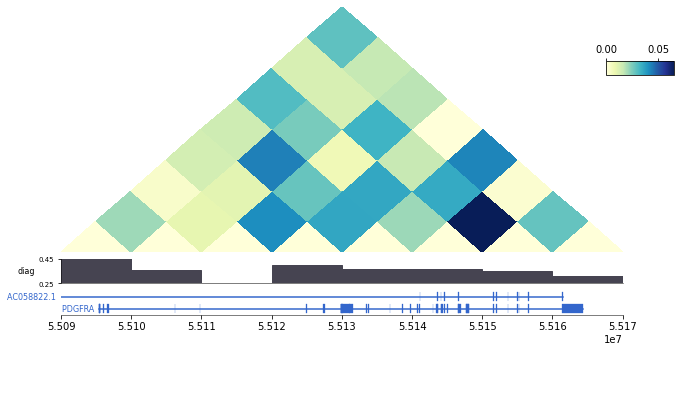

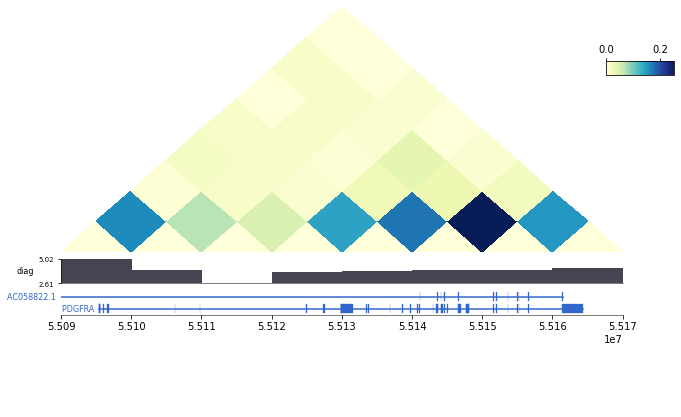

In [11]:
pre_track(show_by_cell_type('ODC')[0])
pre_track(show_by_cell_type('ODC')[1])

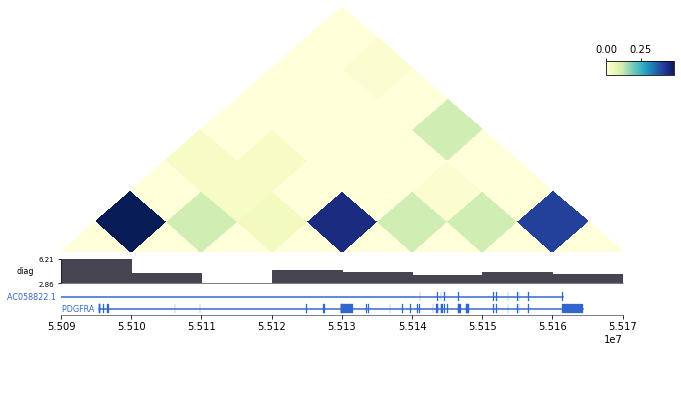

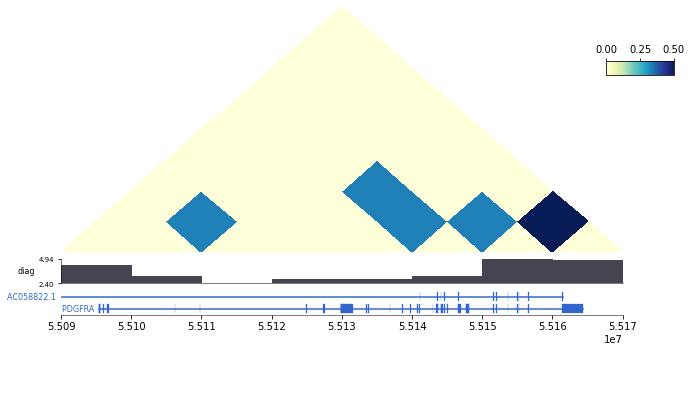

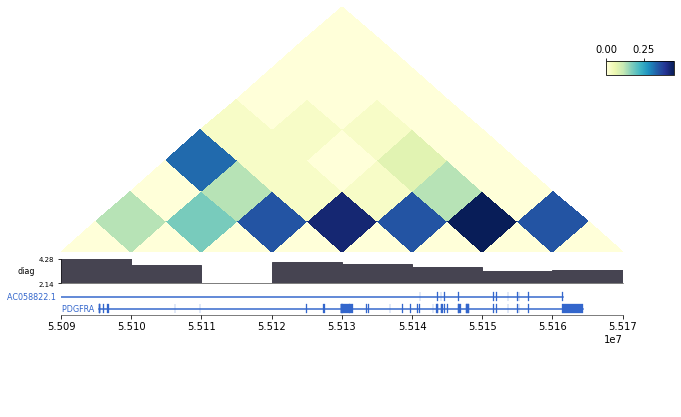

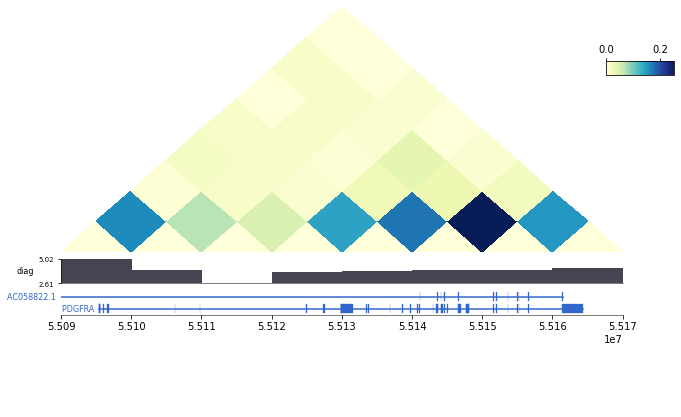

In [12]:
pre_track(show_by_cell_type('Astro')[1])
pre_track(show_by_cell_type('Endo')[1])
pre_track(show_by_cell_type('OPC')[1])
pre_track(show_by_cell_type('ODC')[1])